## Vegetation Identification

This notebook derives a vegetation mask using a robust application of unsupervised and supervised classification workflows. The order of operations is as follows:
  1. Derive a normalised difference vegetation index (NDVI) product as a cloud optimised geotiff
  2. Extract a spatially representative set of pixels from the hyperspectral data cube
  3. Use a combination of UMAP dimensionality reduction and HDBSCAN density clustering to identify vegetated responses
  4. Train a supervised classification model to classify remaining pixels in the hyperspectral data cube

In [7]:
# import standard libaries
import os, warnings, subprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# import gis libraries
import rasterio

# filter warnings for tidy output
warnings.filterwarnings("ignore")

In [8]:
# define a cloud optimised geotiff function that runs GDAL commands as subprocesses
def suprocess_to_cog(input_fn, resample='nearest'):
  # rename the input file
  tmp_fn = input_fn.replace('.tif', '_temporary.tif')
  cmd = 'mv %s %s'%(input_fn, tmp_fn)
  subprocess.call(cmd, shell=True)
  # save zoom levels
  cmd = 'gdaladdo -r %s %s 2 4 8 16'%(resample, tmp_fn)
  subprocess.call(cmd, shell=True)
  # convert to cloud optimised tif
  cmd = 'gdal_translate %s %s -co BIGTIFF=YES -co COMPRESS=LZW -co TILED=YES -co COPY_SRC_OVERVIEWS=YES'%(tmp_fn, input_fn)
  subprocess.call(cmd, shell=True)
  # remove temporary file
  subprocess.call('rm %s'%(tmp_fn), shell=True)

## 1. Windowed NDVI Calculation

Iterate through native blockwindows of the ENVI grid, compute NDVI and save the output to a cloud optimised geotiff. Using native blockwindows makes this maximally efficient in terms of memory usage.

In [9]:
# set path to mosaic ENVI grid
hsi_fn = r'/mnt/c/working/gsq_hyperspec/data/processed/GSQ_block-d_mosaic_ref.dat'

# set path to output NDVI raster
ndvi_fn = r'/mnt/c/working/gsq_hyperspec/data/processed/GSQ_block-d_mosaic_NDVI.tif'

# open the ENVI
with rasterio.open(hsi_fn,'r') as src:
  # create a metadata file for the output
  meta = src.meta.copy()
  meta.update({'count':1, 'dtype':'float32', 'driver':'GTiff', 'BIGTIFF':'YES', 'nodata':-999})
  # get a numpy array of the wavelegnths for each band, use band descriptions
  wvl = np.array([float(x.strip('nm')) for x in src.descriptions])
  # get indices for wavelengths in the RED and VNIR regions for NDVI calculation
  red_idx = np.argwhere(np.logical_and(wvl > 600, wvl < 700))[:,0]
  vnr_idx = np.argwhere(np.logical_and(wvl > 850, wvl < 900))[:,0]
  # open the output file
  with rasterio.open(ndvi_fn,'w',**meta) as dst:
    # iterate through the native blockwindows (rows in ENVI grids)
    blockwindows = [x for x in src.block_windows()]
    for ji, block in tqdm(blockwindows):
      hsi_window = src.read(window=block)[:,0,:].T    # reshape to (Npixels, Nwavelengths)
      window_nodata = hsi_window[:,0] == src.nodata   # find nodata pixels
      # calculate ndvi
      vnr_red_dif = np.mean(hsi_window[:,vnr_idx], axis=1) - np.mean(hsi_window[:,red_idx], axis=1)
      vnr_red_sum = np.mean(hsi_window[:,vnr_idx], axis=1) + np.mean(hsi_window[:,red_idx], axis=1)
      ndvi = vnr_red_dif / vnr_red_sum  
      # mask the nodata pixels and fix any divide by zero issues if they exist
      ndvi[window_nodata] = -999
      ndvi = np.nan_to_num(ndvi, nan=-999, posinf=-999, neginf=-999)
      # write the ndvi data to the output file
      dst.write(np.array([ndvi]), 1, window=block)
    dst.close()
  src.close()

# convert to cloud optimised geotiff with the gdal subprocess function
suprocess_to_cog(ndvi_fn)

100%|██████████| 7285/7285 [05:47<00:00, 20.95it/s]


0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 14387, 7285
0...10...20...30...40...50...60...70...80...90...100 - done.


Visualise the results.

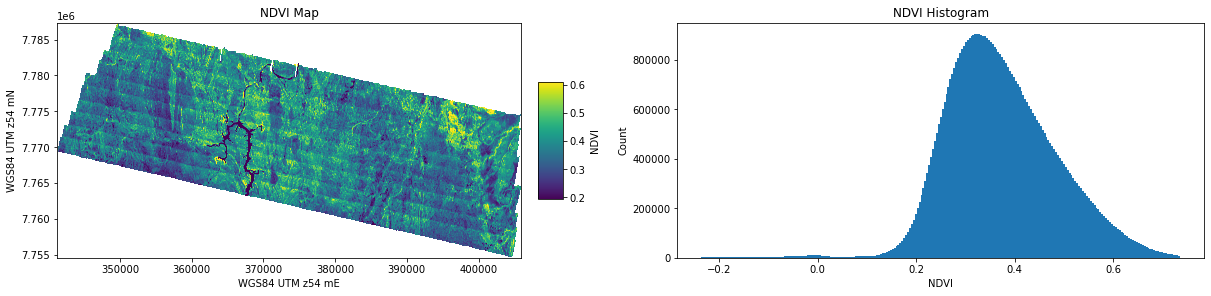

In [5]:
# read the NDVI geotiff into an array, mask the nodata, get raster extents in spatial coordinates
with rasterio.open(ndvi_fn,'r') as src:
  region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
  ndvi_ar = rasterio.open(ndvi_fn,'r').read(1)
  ndvi_ar[ndvi_ar==-999] = np.nan
  src.close()

# plot the NDVI data scaled to 95%
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(17,4), constrained_layout=True)
map = ax0.imshow(ndvi_ar, extent=region, vmin=np.nanpercentile(ndvi_ar,2.5), vmax=np.nanpercentile(ndvi_ar,97.5))
fig.colorbar(map, ax=ax0, shrink=0.5, label='NDVI')
ax0.set(title='NDVI Map', ylabel='WGS84 UTM z54 mN', xlabel='WGS84 UTM z54 mE')

bins = np.linspace(np.nanpercentile(ndvi_ar,0.1), np.nanpercentile(ndvi_ar,99.9), 250)
ax1.hist(ndvi_ar.flatten()[~np.isnan(ndvi_ar.flatten())], bins=bins)
ax1.set(title='NDVI Histogram', ylabel='Count', xlabel='NDVI')
plt.show()

## 2. Spatially Representative Sampling

Generate spatially representative subset of the hyperspectral cube.

In [12]:
# define a spatial resolution for sampling (in metres)
sample_space = 80

# create a list for sample data
pix_data = []

# open the ENVI
with rasterio.open(hsi_fn,'r') as src:
  # determine the sample step using the source resolution
  sample_step = int(sample_space/src.res[0])
  # iterate through the hyperspectral cube's native blockwindows
  blockwindows = [x for x in src.block_windows()]
  for ji, block in tqdm(blockwindows):
    if ji[0] % sample_step == 0: # only consider rows every N sample steps
      hsi_window = src.read(window=block)[:,0,:].T                # reshape to (Npixels, Nwavelengths)
      hsi_window = hsi_window[range(0, src.width, sample_step)]   # sample columns every N sample steps
      pix_data.append(hsi_window)

# concatenate the pixels in the pix_data list
pix_data = np.concatenate(pix_data)
f'Total of {pix_data.shape[0]} pixels sampled every {sample_space}m'

100%|██████████| 7285/7285 [00:12<00:00, 585.38it/s]


'Total of 363363 pixels sampled every 80m'

## 3. Fit UMAP